In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
from os.path import abspath, expanduser
sys.path.append(abspath(expanduser("../RNN")))
sys.path.append(abspath(expanduser("../sequence_annotation")))
import torch
import time
import numpy as np
from sequence_annotation.visual.visual import visual_ann_seq,visual_ann_genome
from sequence_annotation.genome_handler import ann_seq_processor
import deepdish as dd
from sequence_annotation.data_handler.fasta import read_fasta
from sequence_annotation.genome_handler.sequence import AnnSequence
from sequence_annotation.genome_handler.seq_container import AnnSeqContainer
from sequence_annotation.function.data_generator import SeqGenerator
import random
import torch.nn.functional as F
from numpy import median
from sequence_annotation.genome_handler.ann_genome_processor import simplify_genome,get_genome_region_info
from sequence_annotation.data_handler.seq_converter import SeqConverter
from sequence_annotation.pytorch.customize_layer import Concat,PWM#,GatedIndRnnCell
from rnn import RNN

Using TensorFlow backend.


In [231]:
h5=dd.io.load('../io/Arabidopsis_thaliana/data/2018_11_27/Araport11_exon_2018_11_27_merged_with_coordinate_file_megred_exon_dist_to_five_1000_dist_to_three_500_merged.h5')
fasta = read_fasta('../io/Arabidopsis_thaliana/data/2018_11_27/Araport11_exon_2018_11_27_merged_with_coordinate_file_megred_exon_dist_to_five_1000_dist_to_three_500_merged.fasta')
ann_seqs = AnnSeqContainer().from_dict(h5)
seqs_len = [len(seq) for seq in ann_seqs]
seqs_len.sort()
len_threshold = seqs_len[:int(len(seqs_len)/100)][-1]
inner_fasta = {}
for seq in ann_seqs:
    if len(seq) <= len_threshold:
        inner_fasta[seq.id]=fasta[seq.id]
    elif len(seq) >= len_threshold*3:
        outlier_name = seq.id
keys = list(inner_fasta.keys())
random.shuffle(keys)
selected_seqs = AnnSeqContainer()
selected_seqs.ANN_TYPES = ann_seqs.ANN_TYPES
selected_fasta = {}
number = 0
for seq_id in keys:
    selected_seqs.add(ann_seqs.get(seq_id))
    selected_fasta[seq_id]=inner_fasta[seq_id]
    number += 1
selected_seqs = simplify_genome(selected_seqs,{'gene':['exon','intron','mix'],'other':['other']})
print(number)

32


In [3]:
import math
import torch
from torch.nn import functional as F
from torch.nn.init import ones_,zeros_,uniform_,normal_,constant_,eye_
from sequence_annotation.pytorch.customize_layer import noisy_hard_tanh,noisy_hard_sigmoid,noisy_relu
from torch.nn import Hardtanh,Tanh

cell_func = lambda input_size,hidden_size: GatedIndRnnCell(input_size=input_size,hidden_size=hidden_size)

In [221]:
#from sequence_annotation.pytorch.customize_layer import init_GRU
#from torch.nn import Hardtanh, Sigmoid
class Model(nn.Module):
    def __init__(self,out_num,in_num=4,cnn_num=8,rnn_num=2,cnn_out_num=16,rnn_out_num=4):
        super().__init__()
        self.cnns = []
        self.softmax_cnns = []
        self.rnns = []
        self.cnn_bns = []
        self.rnn_bns = []
        self.in_num=in_num
        self.out_num = out_num
        self.cnn_out_num=cnn_out_num
        self.rnn_out_num=rnn_out_num
        self.cnn_num=cnn_num
        self.rnn_num=rnn_num
        self._build_layers()
    def _build_layers(self):
        in_num = self.in_num
        for index in range(1,1+self.cnn_num):
            self.softmax_cnns.append(nn.Conv1d(in_channels=in_num,kernel_size=32,
                                               out_channels=self.cnn_out_num).cuda())
            self.cnns.append(nn.Conv1d(in_channels=in_num,kernel_size=32,
                                       out_channels=self.cnn_out_num).cuda())
            self.cnn_bns.append(nn.LayerNorm(self.cnn_out_num).cuda())
            in_num += self.cnn_out_num
        self.last_cnn_bn = nn.LayerNorm(in_num).cuda()
        #self.linear = IndLinear(in_num).cuda()
        for index in range(self.rnn_num):
            rnn = RNN([cell_func(in_num,self.rnn_out_num),cell_func(in_num,self.rnn_out_num)],
                       bidirectional=True).cuda()
            self.rnn_bns.append(nn.LayerNorm(in_num).cuda())
            self.rnns.append(rnn)
            in_num += (self.rnn_out_num*2)
        if self.rnn_num>0:
            in_num = (self.rnn_out_num*2*self.rnn_num)
        self.last_bn = nn.LayerNorm(in_num).cuda()
        self.last = nn.Conv1d(in_channels=in_num,kernel_size=1,out_channels=self.out_num).cuda()
        for index,cnn_bn in enumerate(self.cnn_bns):
            setattr(self, 'cnn_bn_'+str(index), cnn_bn)
        for index,rnn_bn in enumerate(self.rnn_bns):
            setattr(self, 'rnn_bn_'+str(index), rnn_bn)
        for index,cnn in enumerate(self.cnns):
            setattr(self, 'cnn_'+str(index), cnn)
        for index,rnn in enumerate(self.rnns):
            setattr(self, 'rnn_'+str(index), rnn)
        self.reset_parameters()
    def reset_parameters(self):
        for layer in self.children():
            layer.reset_parameters()
        for cnn in self.cnns:
            normal_(cnn.weight)
            #torch.nn.init.xavier_uniform_(cnn.weight, gain=nn.init.calculate_gain('relu'))
            constant_(cnn.bias,0)
        for rnn in self.rnns:
            if isinstance(rnn,nn.GRU):
                init_GRU(rnn)
        normal_(self.last.weight)
        #torch.nn.init.xavier_uniform_(self.last.weight, gain=nn.init.calculate_gain('linear'))
        constant_(self.last.bias,0)
    def forward(self, x, lengths=None,return_values=False):
        #X shape : N,C,L
        figrue_output = {}
        distribution_output = {}
        input_ = x
        index=0
        for cnn,bn in zip(self.cnns,self.cnn_bns):
            index+=1
            cnn_x = cnn(x)
            post_act_x = noisy_relu()(cnn_x,self.training)
            post_act_x = bn(post_act_x.transpose(1, 2)).transpose(1, 2)
            post_act_x = PWM()(post_act_x)
            x,lengths = Concat(dim=1)([x,post_act_x],lengths)
            figrue_output['x_'+str(index)+'_figure'] = x
            figrue_output['cnn_x_'+str(index)+'_figure'] = cnn_x
            figrue_output['post_act_x_'+str(index)+'_figure'] = post_act_x
        x = self.last_cnn_bn(x.transpose(1, 2)).transpose(1, 2)
        x = PWM()(x)
        distribution_output['cnn_result'] = x
        figrue_output['cnn_result_figure'] = x
        x = x.transpose(1, 2)
        all_rnns = []
        gate_i_list = []
        new_h_list = []
        for index in range(len(self.rnns)):
            rnn = self.rnns[index]
            rnn_bn = self.rnn_bns[index]
            #x= rnn_bn(x)
            rnn_outputs = rnn(packed_x)
            gate_i_list.append(rnn_outputs[rnn.output_names.index('gate_i')].transpose(1, 2))
            new_h_list.append(rnn_outputs[rnn.output_names.index('new_h')].transpose(1, 2))
            rnn_x = rnn_outputs[0]
            #rnn_x -= 0.5
            all_rnns.append(rnn_x)
            #rnn_x = rnn_bn(rnn_x)
            #n_x = PWM()(n_x.transpose(1, 2)).transpose(1, 2)
            if (1+index)==len(self.rnns):
                x = rnn_x
            else:
                x = torch.cat([x,rnn_x],2)
            if isinstance(rnn,RNN):
                for name,rnn_output in zip(rnn.output_names,rnn_outputs):
                    if isinstance(rnn_output,PackedSequence):
                        rnn_output,_ = pad_packed_sequence(rnn_output, batch_first=True)
                    values = rnn_output.transpose(1,2)
                    distribution_output["rnn_"+str(index)+"_"+name] = values
                    figrue_output["rnn_"+str(index)+"_"+name+"_figure"] = values
        
        if len(all_rnns) > 0:
            x = torch.cat(all_rnns,2)
        #x = self.last_bn(x)
        x = x.transpose(1, 2)
        #figrue_output["last_bn"] = x
        x = self.last(x)
        figrue_output["pre_softmax_figure"] = x
        x = F.softmax(x,dim=1)
        if return_values:
            return x,figrue_output,distribution_output
        else:
            return x,new_h_list+gate_i_list

In [222]:
from sequence_annotation.genome_handler.utils import ann_count
ann_count(selected_seqs)

{'gene': 14301.0, 'other': 48000.0}

In [234]:
class GatedIndRnnCell(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self._gate_num = 1
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_weights = torch.nn.Parameter(torch.empty(hidden_size, hidden_size+input_size))
        self.weights_i = torch.nn.Parameter(torch.empty(hidden_size, input_size))
        self.gate_bias = torch.nn.Parameter(torch.empty(hidden_size))
        self.bn = nn.LayerNorm(hidden_size+ input_size).cuda()
        self.gate_function =  noisy_hard_sigmoid(c=1)
        self.recurrent_function = noisy_hard_sigmoid(c=1)
        self.reset_parameters()
        self.output_names = ['new_h','concat_input','pre_gate_i','gate_i','values_i','pre_h']
    def reset_parameters(self):
        gate_bound = (1/((self.input_size+self.hidden_size)))
        input_bound = (1/(self.input_size))
        uniform_(self.gate_weights,-gate_bound,gate_bound)
        uniform_(self.weights_i,-input_bound,input_bound)
        constant_(self.gate_bias,0.5)
    def forward(self, input, state):
        #input shape should be (number,feature size)
        concat_input = torch.cat([input,state], dim=1)
        pre_gate_i = F.linear(concat_input, self.gate_weights,self.gate_bias)
        gate_i = self.gate_function(pre_gate_i,training=self.training)
        values_i = F.linear(input, self.weights_i)
        values_i = Tanh()(values_i)
        pre_h = state+ values_i*gate_i
        new_h = self.recurrent_function(pre_h,training=self.training)
        return new_h,concat_input,pre_gate_i,gate_i,values_i,pre_h

In [237]:
class SeqAnnlLoss(nn.Module):
    def __init__(self, class_num,alphas=None, gamma=0,ignore_index=None):
        super().__init__()
        self.gamma = gamma
        self._ignore_index = ignore_index
        self._class_num = class_num
        self._alphas = alphas
    def forward(self, output, target,spatial_weights=None):
        """data shape is N,C,L"""
        pt = output[0]
        gate_i = output[1]
        center=0.5
        gate_loss_ = ((center**2)-(torch.cat(gate_i,1)-center)**2).mean(1)
        input_length = pt.shape[2]
        if list(pt.shape) != list(target.shape):
            target = target.transpose(0,2)[:input_length].transpose(0,2)
        target = target.float()
        if self._ignore_index is not None:
            mask = (target.max(1)[0] != self._ignore_index).float()
        decay_cooef = (1-pt)**self.gamma
        loss_ =  -decay_cooef* (pt+1e-10).log() * target
        if spatial_weights is not None:
            if list(pt.shape) != list(spatial_weights.shape):
                 spatial_weights = spatial_weights.transpose(0,2)[:input_length].transpose(0,2)
            spatial_weights = torch.FloatTensor(spatial_weights).cuda()
        if self._alphas is not None:
            loss_ = loss_*self._alphas
        loss_ = loss_.sum(1)
        if self._ignore_index is not None:
            gate_loss_ = gate_loss_*mask
            loss_ = loss_*mask
            loss = loss_.sum()/mask.sum()
            gate_loss = gate_loss_.sum()/mask.sum()
        else:
            loss = loss_.mean()
            gate_loss = gate_loss_.mean()
        return loss + gate_loss


In [238]:
class_num=len(selected_seqs.ANN_TYPES)
model = Model(class_num,cnn_out_num=16,rnn_out_num=2,cnn_num=8,rnn_num=2)

In [239]:
from sequence_annotation.process.ann_seq_data import AnnSeqData
from sequence_annotation.pytorch.worker import Trainer
from sequence_annotation.process.pipeline import Pipeline 
from sequence_annotation.function.model_processor import SimpleModel
from sequence_annotation.pytorch.compiler import SimpleCompiler
import torch.optim as optim
from sequence_annotation.pytorch.customize_layer import FocalLoss
from sequence_annotation.pytorch.callback import CategoricalMetric,TensorboardCallback,TensorboardWriter,SeqFigCallback
from tensorboardX import SummaryWriter
import shutil
#shutil.rmtree('../io/record/train_2019_02_16_model_3_lr_3', ignore_errors=True)
writer = TensorboardWriter(SummaryWriter('../io/record/train_2019_02_16_model_5_rnn_zero_center'))

loss = SeqAnnlLoss(class_num=class_num,ignore_index=-1,gamma=0).cuda()
builder = SimpleModel(model)
compiler = SimpleCompiler(lambda params:optim.Adam(params,lr=0.01),loss)
data = AnnSeqData({'training':{'inputs':selected_fasta,'answers':selected_seqs}},
                   discard_invalid_seq=True,validation_split=0.1)
train_metric = CategoricalMetric(class_num=class_num,ignore_index=-1,class_names=selected_seqs.ANN_TYPES)
val_metric = CategoricalMetric(prefix='val',class_num=class_num,ignore_index=-1,class_names=selected_seqs.ANN_TYPES)
tensorboard = TensorboardCallback(writer)
seq = SeqConverter().seq2vecs(fasta[outlier_name])
seq = np.transpose(np.array([seq]),[0,2,1])
seq = torch.from_numpy(seq).type('torch.FloatTensor').cuda()
seq_fig = SeqFigCallback(writer,seq,class_names=selected_seqs.ANN_TYPES,colors=['blue','red'],prefix='test')
worker = Trainer(batch_size=16,return_extra_info=True, order='NCL', order_target=['answers','inputs'],
                 pad_value={'answers':-1,'inputs':0},epoch_num=100,generator=SeqGenerator,
                 train_callbacks=[train_metric],val_callbacks=[val_metric],other_callbacks=[tensorboard,seq_fig],
                writer=writer)
pipeline = Pipeline(builder,data,worker,compiler,
                    is_prompt_visible=True)
pipeline.execute()

Processing data...
Processing model..
Compiling model...
Processing worker...
Executing...
Start working(2019-02-17 08:54:06)
1 {'val_loss': 0.8765599131584167, 'F1_gene': 0.4191321841073844, 'val_accuracy': 0.277872420972932, 'val_F1_gene': 0.4348985335505851, 'loss': 0.7831479012966156, 'accuracy': 0.26512791258940716, 'F1_other': 0.0, 'val_F1_other': 0.0}
2 {'val_loss': 0.8378812670707703, 'F1_gene': 0.41909188664192304, 'val_accuracy': 0.28052243043725156, 'val_F1_gene': 0.4352993611647601, 'loss': 0.8734314143657684, 'accuracy': 0.26512791258940716, 'F1_other': 0.00011941011403665891, 'val_F1_other': 0.008865710560625815}
3 {'val_loss': 0.7859598398208618, 'F1_gene': 0.41768645464427223, 'val_accuracy': 0.3333333333333333, 'val_F1_gene': 0.4308338720103426, 'loss': 0.8286062479019165, 'accuracy': 0.2712712273465268, 'F1_other': 0.026496277624714227, 'val_F1_other': 0.19552306989492918}
4 {'val_loss': 0.7226979732513428, 'F1_gene': 0.005587510271158586, 'val_accuracy': 0.7219382926

33 {'val_loss': 0.6177104711532593, 'F1_gene': 0.9616858237547893, 'val_accuracy': 0.6910846110164679, 'val_F1_gene': 0.20390243902439023, 'loss': 0.1301436424255371, 'accuracy': 0.9798148229408925, 'F1_other': 0.9862981055641606, 'val_F1_other': 0.8083607327383748}
34 {'val_loss': 0.6237592101097107, 'F1_gene': 0.9694315928618639, 'val_accuracy': 0.6891917471133826, 'val_F1_gene': 0.19667318982387474, 'loss': 0.1213526539504528, 'accuracy': 0.9837640967133267, 'F1_other': 0.9889466451574356, 'val_F1_other': 0.8073222248298522}
35 {'val_loss': 0.6436880826950073, 'F1_gene': 0.9705226653455536, 'val_accuracy': 0.6855953056975204, 'val_F1_gene': 0.1707438841737394, 'loss': 0.11356929317116737, 'accuracy': 0.9843345473693449, 'F1_other': 0.9893327755699645, 'val_F1_other': 0.8060259254934018}
36 {'val_loss': 0.640314519405365, 'F1_gene': 0.972330056991823, 'val_accuracy': 0.6810524323301155, 'val_F1_gene': 0.16210840377921432, 'loss': 0.10644577443599701, 'accuracy': 0.9852999254026065, '

64 {'val_loss': 0.6066415905952454, 'F1_gene': 0.9755738910219753, 'val_accuracy': 0.7526026878667423, 'val_F1_gene': 0.512858740216176, 'loss': -0.00047574564814567566, 'accuracy': 0.9868796349115802, 'F1_other': 0.9910309865914749, 'val_F1_other': 0.8342001775973614}
65 {'val_loss': 0.626408576965332, 'F1_gene': 0.9743715712765086, 'val_accuracy': 0.7291311754684838, 'val_F1_gene': 0.42460796139927626, 'loss': -0.002587679773569107, 'accuracy': 0.9862653034358682, 'F1_other': 0.9906189120335681, 'val_F1_other': 0.8228741180839213}
66 {'val_loss': 0.7261996865272522, 'F1_gene': 0.9742875859810023, 'val_accuracy': 0.7156918417565777, 'val_F1_gene': 0.3497835497835498, 'loss': -0.005184605717658997, 'accuracy': 0.9862214226161745, 'F1_other': 0.9905892225618893, 'val_F1_other': 0.8180717054263565}
67 {'val_loss': 0.7335096001625061, 'F1_gene': 0.9751781764561317, 'val_accuracy': 0.7124739731213325, 'val_F1_gene': 0.3375490623637157, 'loss': -0.006735071539878845, 'accuracy': 0.986704111

95 {'val_loss': 0.8050752282142639, 'F1_gene': 0.012485625102677839, 'val_accuracy': 0.7225061518076851, 'val_F1_gene': 0.0027210884353741495, 'loss': 0.633609414100647, 'accuracy': 0.7362323928210979, 'F1_other': 0.847788103618546, 'val_F1_other': 0.838830255057168}
96 {'val_loss': 0.726872980594635, 'F1_gene': 0.010517666392769104, 'val_accuracy': 0.7221275790270679, 'val_F1_gene': 0.005420054200542005, 'loss': 0.5990846455097198, 'accuracy': 0.7357935846241608, 'F1_other': 0.8475426024865166, 'val_F1_other': 0.8385038503850385}
97 {'val_loss': 0.6863845586776733, 'F1_gene': 0.10953226761397276, 'val_accuracy': 0.696763202725724, 'val_F1_gene': 0.20927936821322804, 'loss': 0.5404892563819885, 'accuracy': 0.7360129887226293, 'F1_other': 0.8450363196125908, 'val_F1_other': 0.8124121779859484}
98 {'val_loss': 0.6668919920921326, 'F1_gene': 0.23677815067700497, 'val_accuracy': 0.7047132311186826, 'val_F1_gene': 0.18580375782881003, 'loss': 0.5343433916568756, 'accuracy': 0.71060599411997

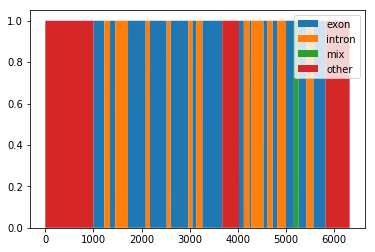

In [232]:
visual_ann_seq(ann_seqs.get(outlier_name))

In [61]:
noisy_relu(c=0.5)(torch.FloatTensor([-100000000000]).cuda(),True)

tensor([-0.2392], device='cuda:0')

In [240]:
a={'a':1}
b={'r':3}
a.update(b)

In [242]:
b

{'r': 3}